# Implementing a Nearest Neighbor Classifier
In this notebook, we implement and evaluate a very simple learning method for classification. The data will come from the MNIST dataset of handwritten digit images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.io import loadmat
from matplotlib import cm

sns.set(context = 'notebook', style = 'whitegrid')

% matplotlib inline

# Convenience functions
Below we define **show_imgs**, which displays 10 random images from a given MNIST set, and **error**, which calculates the proportion of predictions that have been mis-classified.

In [2]:
def show_imgs(dataset):
    "displays 10 random images from training or test split of the MNIST dataset"
    fig, axes = plt.subplots(1, 10, figsize = (16, 4))
    n_instances = dataset.shape[0]
    for ax in axes:
        index = np.random.choice(n_instances, 1)[0]
        img = dataset[index,:].reshape(28,28)
        ax.imshow(img, cmap = cm.gray_r)
        ax.axis('off')
    
def error(y, y_pred):
    "calculate proportion of predictions that have been mis-classified"
    return np.mean(y != y_pred)

# MNIST Handwritten Digits
The MNIST images are $28 \times 28$ pixel images rendered in grayscale, with each pixel taking on a value between $0$ and $255$. Each image is of a handwritten digit between $0$ and $9$.

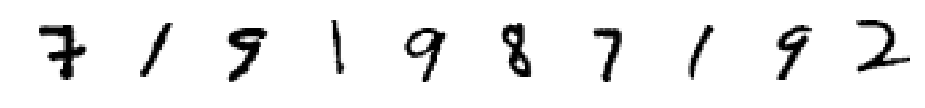

In [4]:
ocr = loadmat('data/ocr.mat')
show_imgs(ocr['data'])

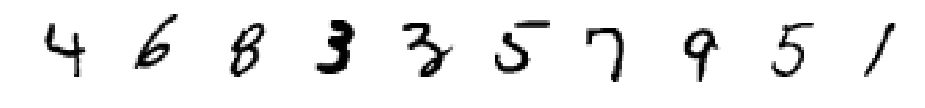

In [5]:
show_imgs(ocr['testdata'])

There are **60000** training instances and **10000** test instances. Moreover, it appears the distribution of digits in both train and test sets is uniform.

number of training instances: 60000
number of test instances: 10000


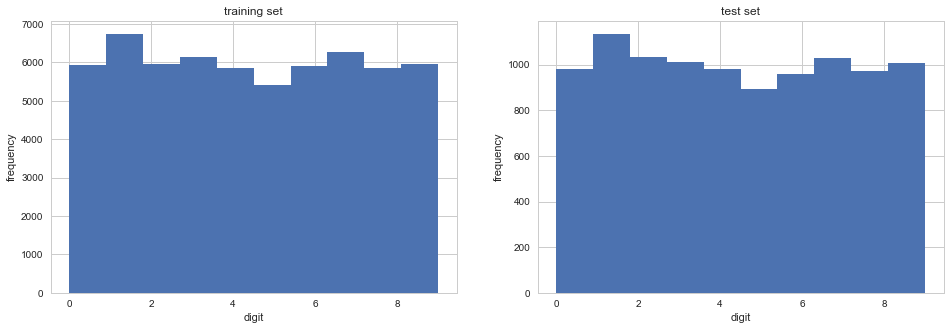

In [373]:
print('number of training instances:', ocr['data'].shape[0])
print('number of test instances:', ocr['testdata'].shape[0])

fig, axes = plt.subplots(1, 2, figsize = (16, 5))

axes[0].hist(ocr['labels'].squeeze())
axes[0].set(title = 'training set', xlabel = 'digit', ylabel = 'frequency')
axes[1].hist(ocr['testlabels'].squeeze())
axes[1].set(title = 'test set', xlabel = 'digit', ylabel = 'frequency');

# Nearest Neighbor Classifier
Let the training examples be denoted by $(x_1, y_1), ..., (x_n, y_n)$ (for $n = 60000$), where each $x_i \in \mathbb{R}^d$ and each $y_i \in \{0, .., 9\}$. The *nearest neighbor classifier* $\hat{f}: \mathbb{R}^d \rightarrow \{0, ..., 9\}$ is a function defined in terms of the $60000$ training examples as follows. On input $x \in \mathbb{R}^d$, let $i(x) := \arg\min_{i \in \{1, ..., n\}} \left\|x - x_i\right\|_2$, breaking ties arbitrarily, and return $y_{i(x)}$. That is, given an input $x$, find its nearest neighbor (one of the training examples) in terms of the $L2$ norm.

The classifier below takes **fits** on a matrix of training feature vectors **X** and a vector of corresponding training labels **y**. It then **predicts** a vector of predicted labels given a matrix of test feature vectors.

Let $X \in \mathbb{R}^{n \times d}$ be the features for $n$ training instances and $T \in \mathbb{R}^{m \times d}$ be the features of $m$ test instances. Let $t_i^T$ and $x_j^T$ be the $i^{th}$ and $j^{th}$ rows of $T$ and $X$, respectively. Then we can leverage the following identity for the squared Euclidean distance to speed up the combination of all pair-wise distances between instances in $X$ and $T$.

$$\left\|t_i - x_j\right\|^2_2 = (t_i - x_j)^T(t_i-x_j)=t_i^Tt_i-2t_i^Tx_j+x_j^Tx_j$$

That is, the Euclidean distance between two vectors $u$ and $v$ is the sum of their respective squared norms minus 2 times the dot product of $u$ and $v$.

In [262]:
class NearestNeighborClassifier():
    
    training_data = None
    training_labels = None
    
    def __init__(self):
        return
        
    def fit(self, X, y):
        self.training_data = X
        self.training_labels = y
        self.training_data = self.training_data.astype('float') # in case datatype is unsigned
        self.training_labels = self.training_labels.squeeze() # in case vector is not one-dimensional
    
        assert(len(self.training_data.shape) == 2)
        assert(len(self.training_labels.shape) == 1)
        
        return self
        
    def predict(self, X):
        T = X.astype('float') # T for 'test data'
        X = self.training_data
        
        # calculate individual summands. let m be size of training set and n that of test set
        T_norms = np.dot(T ** 2, np.ones(T.shape[1])) # n-dimensional vector
        X_norms = np.dot(X ** 2, np.ones(X.shape[1])) # m-dimensional vector
        TX = 2 * np.dot(T, X.T) # n by m dimensional matrix
        
        # prepare vectors for broadcasting
        T_norms = np.expand_dims(T_norms, axis = 1)
        X_norms = np.expand_dims(X_norms, axis = 0)
        
        # calculate squared Euclidean distances between every pair of observations between X and T
        # broadcasting operations will produce an n by m dimensional amtrix
        # each row contains distances to all training instances for a single test instance
        distance_matrix = -TX + T_norms + X_norms
        
        # find the index of minimum distance for each row
        min_indices = np.argmin(distance_matrix, axis = 1)
        
        # uses indices to return corresponding labels of training data
        preds = self.training_labels[min_indices]
        
        return preds

# Learning Curve
Instead of training the classifier on the entire training set, for each value of $n \in \{1000, 2000, 4000, 8000, 16000, 32000\}$, we do the following:
1. Uniformly at random choose $n$ points from the training set together with their corresponding labels.
2. Use these $n$ points as the training data and the entirety of the test set to compute the classifier's error rate.

We repeat the above procedure $10$ times to produce an estimate of the learning curve plot, averaging over each repetition.

In [343]:
ocr = loadmat('data/ocr.mat')

n_list = [1000, 2000, 4000, 8000, 16000, 32000]
n_trials = 10
n_training_obs = ocr['data'].shape[0]
n_test_obs = ocr['testdata'].shape[0]

X_test = ocr['testdata']
y_test = ocr['testlabels'].squeeze()

error_matrix = list()
for i in range(n_trials):
    error_row = list()
    for n in n_list:
        rand_indices = np.random.choice(n_training_obs, n)
        X_train = ocr['data'][rand_indices, :]
        y_train = ocr['labels'].squeeze()[rand_indices]
        y_pred = NearestNeighborClassifier().fit(X_train, y_train).predict(X_test)
        error_row.append(error(y_test, y_pred))
    error_matrix.append(error_row)
error_matrix = np.array(error_matrix)

The training error rate is not included, as it would always be $0$. However, we can clearly see that the addition of more training data improves the performance and generalizability of the nearest neighbor classifier to previously unseen MNIST images.

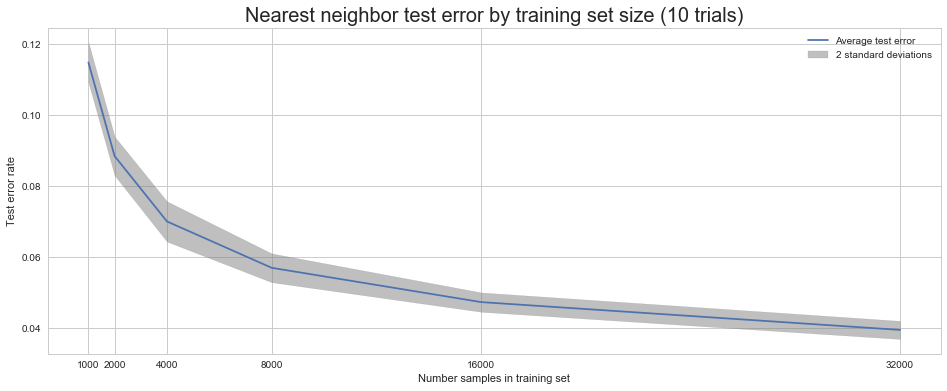

In [378]:
stds = np.std(error_matrix, axis = 0)
means = np.mean(error_matrix, axis = 0)

plt.figure(figsize = (16,6))
plt.plot(n_list, means, label = 'Average test error'.format(n_trials))
plt.fill_between(n_list, means - 2 * stds, means + 2 * stds, color = 'gray',
                 alpha = 0.5, label = '2 standard deviations')
plt.xlabel('Number samples in training set')
plt.xticks(n_list)
plt.ylabel('Test error rate')
plt.title('Nearest neighbor test error by training set size ({} trials)'.format(n_trials), fontsize = 20)
plt.legend(loc='best');